<center><h1>Combinaison d'algorithmes pour modéliser une prime</h1></center>

Vous trouverez ci-dessous un notebook proposant une première modélisation d'une prime d'une garantie auto
</br>Chaque ligne correspond à une exposition annuelle au risque
</br>Parmi les variables à expliquer :
<lu>
    <li>CHARGE => charge de sinistralité annuelle</li>
    <li>NB => Nombre de sinistres sur la période de l'année couverte</li>
    <li>EXPO => la durée annuelle d'exposition au risque</li>
    <li>FREQ => NB/EXPO</li>
    <li>COUT_MOYEN => COUT/NB</li>
</lu>
Les autres variables sont les variables explicatives avec pour toute variable X_PREC = 1 s'il y a eu un sinistre sur la garantie X par le passé

Votre objectif est de faire évoluer l'ensemble du notebook pour optimiser deux métriques sur la base de test :
<lu>
    <li><b>Métrique 1</b> : Minimisation de l'erreur quadratique moyenne de la prime </li>
    <li><b>Métrique 2</b> : Convergence du ratio Sinistres/Primes vers 1</li>
</lu>

La proposition ci-dessous ne tient pas compte de la variable EXPO, libre à vous de l'intégrer ou non aux travaux.
</br>Le fait de ne pas considérer la variable EXPO ne sera pas évalué et ne sera donc pas pénalisant

Vous pouvez opter pour l'une des stratégies suivantes :
<lu>
    <li><b>Stratégie 1</b> : Modélisation FREQ * COUT_MOYEN </li>
    <li><b>Stratégie 2</b> : Modélisation PROBA_SINISTRE * COUT où la variable COUT = CHARGE > 0</li>
    <li><b>Stratégie 3</b> : Modélisation directement de la charge</li>
</lu>

## ATTENTION Certains blocs de code ci-dessous ne doivent pas être modifiés
Via le libellé "Ne pas changer le bloc ci-dessous", il vous faudra juste comprendre et exécuter le bloc qui suit.
</br>A la lecture de ces blocs, vous comprendrez qu'il s'agira de benchmarker votre modélisation

## VOTRE RENDU

Merci de respecter les consignes suivantes :<lu>
    <li><b>Ce notebook complété</b> : des codes, des commentaires et des résultats obtenus</li>
    <li><b>Un page A4 au format PDF</b> : recensant l'ensemble des modèles testés et résultats obtenus ainsi que les next steps à envisager</li>
</lu>
</br>De manière facultative :
<lu>
    <li><b>Un 2nd notebook</b> : si vous hésitez entre deux modèles lors de l'analyse de vos résultats</li>
    <li><b>Tout reporting</b> : se reportant à la préparation de la donnée ou autre</li>
</lu>

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import plotly.express as px

from visualisation import (
    plot_classification_metrics,
    qqplot_plotly
)


In [5]:
bdd = pd.read_csv('./db_auto_dm_2025.csv',sep=";")
bdd.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39944 entries, 0 to 39943
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         39944 non-null  int64  
 1   CHARGE             39944 non-null  float64
 2   NB                 39944 non-null  int64  
 3   EXPO               39944 non-null  float64
 4   FREQ               39944 non-null  float64
 5   COUT_MOYEN         39944 non-null  float64
 6   ANNEE_EXPO         39944 non-null  int64  
 7   ANNEE_VEHICULE     39944 non-null  int64  
 8   ZONE_RISQUE        39944 non-null  object 
 9   AGE_ASSURE         39944 non-null  object 
 10  ANCIENNETE_PERMIS  39944 non-null  object 
 11  ANCIENNETE_ASSURE  39944 non-null  object 
 12  GENRE_ASSURE       39944 non-null  object 
 13  NB_KM              39944 non-null  object 
 14  SECOND_CONDUCTEUR  15508 non-null  object 
 15  FORMULE            39944 non-null  object 
 16  MODALITE_PAIEMENT  399

In [6]:
bdd2 = bdd.iloc[:,1:].copy()

In [7]:
px.histogram(bdd2.loc[bdd2['CHARGE']>0, 'CHARGE'],nbins=200)

Ratio du nombre de contrats, avec une 'charge' > 20k :

In [8]:
bdd2.loc[bdd2.CHARGE > 20000,'CHARGE'].count()/bdd2['CHARGE'].count()

0.0008011215701982776

Part de representation de ces outliers dans la somme des charges :

In [9]:
bdd2.loc[bdd2.CHARGE > 20000,'CHARGE'].sum()/bdd2['CHARGE'].sum()

0.15731558738414747

In [8]:
bdd2.loc[bdd2.CHARGE > 20000,'CHARGE'].sum()/bdd2['EXPO'].sum()

29.08763241187885

In [9]:
bdd2.loc[bdd2.CHARGE <= 20000,'CHARGE'].sum()/bdd2['EXPO'].sum()

155.8122423910549

## Ne pas changer le bloc ci-dessous - Préparation des données

In [10]:
# Ne pas modifier
bdd3 = bdd2.loc[bdd2.CHARGE < 20000]
features = bdd3.drop(columns=['CHARGE','NB','EXPO','COUT_MOYEN','FREQ'])
couts = np.asarray(bdd3['CHARGE'])
y = couts.copy()
y[y>0] = 1
expos = bdd3[['EXPO']]

## Analyse descriptives et data engineering

In [219]:
#from ydata_profiling import ProfileReport

#profile = ProfileReport(bdd3, title="prime-auto.html")

#profile.to_file(output_file='rapport-prime-auto.html')

In [50]:
def summarize_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    def top3_distrib(series: pd.Series) -> list[str | None]:
        value_counts = series.value_counts(normalize=True)
        top3 = value_counts.head(3)
        return [f"{idx} ({round(pct*100,2)}%)" for idx, pct in top3.items()] + [None]*(3-len(top3))
    
    
    data = [[
        df[c].unique(),
        len(df[c].unique()),
        df[c].isnull().sum(),
        np.round((df[c].isnull().sum() / df.shape[0]) * 100, 1),
        df.dtypes[c],
        *top3_distrib(df[c])
    ] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                        columns=['Levels', 'No. of Levels', 'No. of Missing Values', '% empty', 'type',
                                 'Top1', 'Top2', 'Top3'])

    return df_temp

summarize_categoricals(bdd3.round(2))

,Levels,No. of Levels,No. of Missing Values,% empty,type,Top1,Top2,Top3
CHARGE,"[4121.41, 0.0, 2500.0, 5697.29, 105.3, 111.15,...",1582,0,0.0,float64,0.0 (94.67%),2500.0 (0.24%),105.3 (0.18%)
NB,"[1, 0, 2]",3,0,0.0,int64,0 (94.67%),1 (5.1%),2 (0.24%)
EXPO,"[1.0, 0.24, 0.86, 0.42, 0.99, 0.98, 0.06, 0.83...",101,0,0.0,float64,1.0 (48.17%),0.83 (9.04%),0.5 (0.8%)
FREQ,"[1.0, 0.0, 3.3, 8.49, 1.34, 1.23, 1.11, 2.87, ...",244,0,0.0,float64,0.0 (94.67%),1.0 (3.05%),1.2 (0.24%)
COUT_MOYEN,"[4121.41, 0.0, 2500.0, 2848.64, 105.3, 111.15,...",1580,0,0.0,float64,0.0 (94.67%),2500.0 (0.25%),105.3 (0.19%)
ANNEE_EXPO,"[2021, 2022, 2024, 2023, 2020, 2019]",6,0,0.0,int64,2023 (19.21%),2022 (18.86%),2021 (17.16%)
ANNEE_VEHICULE,"[2019, 2020, 2018, 2016, 2013, 2017, 2022, 201...",19,0,0.0,int64,2019 (25.44%),2018 (13.73%),2016 (13.13%)
ZONE_RISQUE,"[D, B, C, E, A, G, J, K, H]",9,0,0.0,object,D (39.59%),C (27.14%),B (25.25%)
AGE_ASSURE,"[(45,55], (55,65], (40,45], (65,75], (35,40], ...",7,0,0.0,object,"(45,55] (31.26%)","(55,65] (21.43%)","(40,45] (12.82%)"
ANCIENNETE_PERMIS,"[(25,60], (12,25], (8,12], (4,6], (6,8], (2,4]...",8,0,0.0,object,"(25,60] (76.49%)","(12,25] (18.29%)","(8,12] (3.34%)"


## zoom sur les changements structurels du dataset

### Données manquantes :
-> impute by ["missing"] strategy
- SECOND_CONDUCTEUR : 24413 missing values (61.2%)  


### Mauvais types :

interpreation en classes

- ZONE_GEO : int -> to object
- ANNEE_EXPO : int -> to object
- ANNEE_VEHICULE : int -> to object

valiarbles 0 ou 1

- RC_PREC_AN1 :  int -> to object,
- RC_PREC_AN2 :  int -> to object,
- DM_PREC :  int -> to object,
- BIV_PREC :  int -> to object


### Variables déséquilibrées : 
-> Choisir un KFOLD **stratifié**
- NB is highly imbalanced (80.2%)	
- ANCIENNETE_PERMIS is highly imbalanced (65.3%)	
- FORMULE is highly imbalanced (98.4%)	
- NIVEAU_ANTIVOL is highly imbalanced (59.3%)	
- LEASING is highly imbalanced (72.9%)	
- RC_PREC_AN1 is highly imbalanced (80.9%)	
- RC_PREC_AN2 is highly imbalanced (87.3%)	
- DM_PREC is highly imbalanced (92.6%)	
- BIV_PREC is highly imbalanced (93.4%)
  


### warnings, valeurs nulles :
- CHARGE has 37783 zeros(94.7%) 	
- FREQ has 37783 zeros (94.7%)	
- COUT_MOYEN has 37783 zeros (94.7%)


On change ici le type des années et zones géo, en variables catégorielles, cela va nous permettre de considérer chaques modalitées séparément et de leur calculer un coeficient unique à chaques valeurs.

- pour les zones géo, car on veux que chaques régions aient son propre coeficient.
- pour l'année d'exposition, même chose, on souahite que le modèle détermine lui même le coeficient  (si une année exposée est plus favorable aux primes par exemple)
- pour l'année du véhicule, on cherche aussi à calculer les coeficient de chaques années... mais on introduit un biais : l'âge du véhicule. En effet un 2019 peut représenter un véhicul neuf pour une expo en 2019, et 4 ans pour un vehicule ancien.
  - -> on modifie donc cette variable par $ \text{Age\_vehicule} = \text{Anne\_expo} - \text{Anne\_vehicule}  $



In [30]:
bdd4 = bdd3.copy()

# Créer AGE_VEHICULE en castant explicitement en int
#bdd4["AGE_VEHICULE"] = bdd4["ANNEE_EXPO"].astype("int") - bdd4["ANNEE_VEHICULE"].astype("int")

# Convertir les colonnes en string

for col in ["ZONE_GEO", "ANNEE_EXPO"]:
    bdd4[col] = bdd4[col].astype("object")

for col in ["RC_PREC_AN1", "RC_PREC_AN2", "DM_PREC", "BIV_PREC"]:
    bdd4[col] = bdd4[col].astype("object")

# Supprimer ANNEE_VEHICULE
#bdd4 = bdd4.drop(columns="ANNEE_VEHICULE")

## Annalyse des correlations

### Quantilisation (binning)

Nous allons utiliser un diagramme de correlation de pearson (similair au v de cramer)

Pour ce faire nous avons besoin de quantiliser nos variables quantitatives (ici déciles)

In [31]:
def num_to_cat(df_:pd.DataFrame, q=10, ignore_int=True, verbose=False)->pd.DataFrame:
    """ Convertit les variables numériques en déciles (catégorielles)"""
    df = df_.copy()
    for column in df.select_dtypes(include=['float64' if ignore_int else 'number']).columns:
        col = df[column]
        # découpe en 9 déciles en excluant les 0
        deciles, bins = pd.qcut(col.loc[col != 0], q=q-1, labels=False, retbins=True, duplicates='drop', precision=8)
        bins = [round(float(x), 2) for x in bins]
        # imperatif d'afficher les bins pour debug
        print(f"Converting {column} , déciles utilisés: {bins}")
        # inclure 0 dans le premier décile
        deciles = deciles +1
        bins = [0] + bins
        # créer une série avec les mêmes index que col, initialisée à "0"
        result = pd.Series("[0]", index=col.index)
        # créer les labels des déciles
        decile_labels = [f"({round(bins[i],1)},{round(bins[i+1],1)}]" for i in range(len(bins)-1)]
        # affecter noms de déciles aux individus
        result.loc[col != 0] = deciles.map(lambda d: decile_labels[int(d)] if pd.notnull(d) else d).values
        if verbose:
            print(result.value_counts())
        df[column] = result

    if ignore_int:
        for col in df.select_dtypes(include=['int']).columns:
            print(f"Converting {col} (int) directly to object")
            df[col] = df[col].astype('object')
    return df

Au vu des données, seules les variables continues seront quantilisées.
Les variables déjà en int ne présentes déja que trop peu de niveau (<10) il est donc innutile de les traiter et de perdre de l'information.

In [28]:
categorical_df = num_to_cat(bdd4,q=20, ignore_int=True)

Converting CHARGE , déciles utilisés: [0.81, 109.98, 117.0, 279.46, 491.7, 672.19, 829.43, 1009.49, 1199.56, 1382.31, 1602.17, 1834.41, 2142.78, 2500.0, 2610.22, 3124.1, 3801.89, 4889.37, 7609.06, 19449.3]
Converting EXPO , déciles utilisés: [0.0, 0.15, 0.29, 0.43, 0.54, 0.64, 0.74, 0.83, 0.83, 0.88, 1.0, 1.0, 1.0]
Converting FREQ , déciles utilisés: [1.0, 1.0, 1.0, 1.02, 1.16, 1.2, 1.38, 1.57, 1.94, 2.17, 3.21, 243.33]
Converting COUT_MOYEN , déciles utilisés: [0.81, 109.98, 117.0, 276.28, 479.57, 663.88, 819.97, 982.59, 1155.4, 1338.28, 1551.91, 1773.11, 2012.27, 2421.1, 2500.0, 2905.88, 3514.47, 4623.81, 7367.07, 19449.3]
Converting NB (int) directly to object
Converting NIVEAU_ANTIVOL (int) directly to object
Converting AGE_VEHICULE (int) directly to object


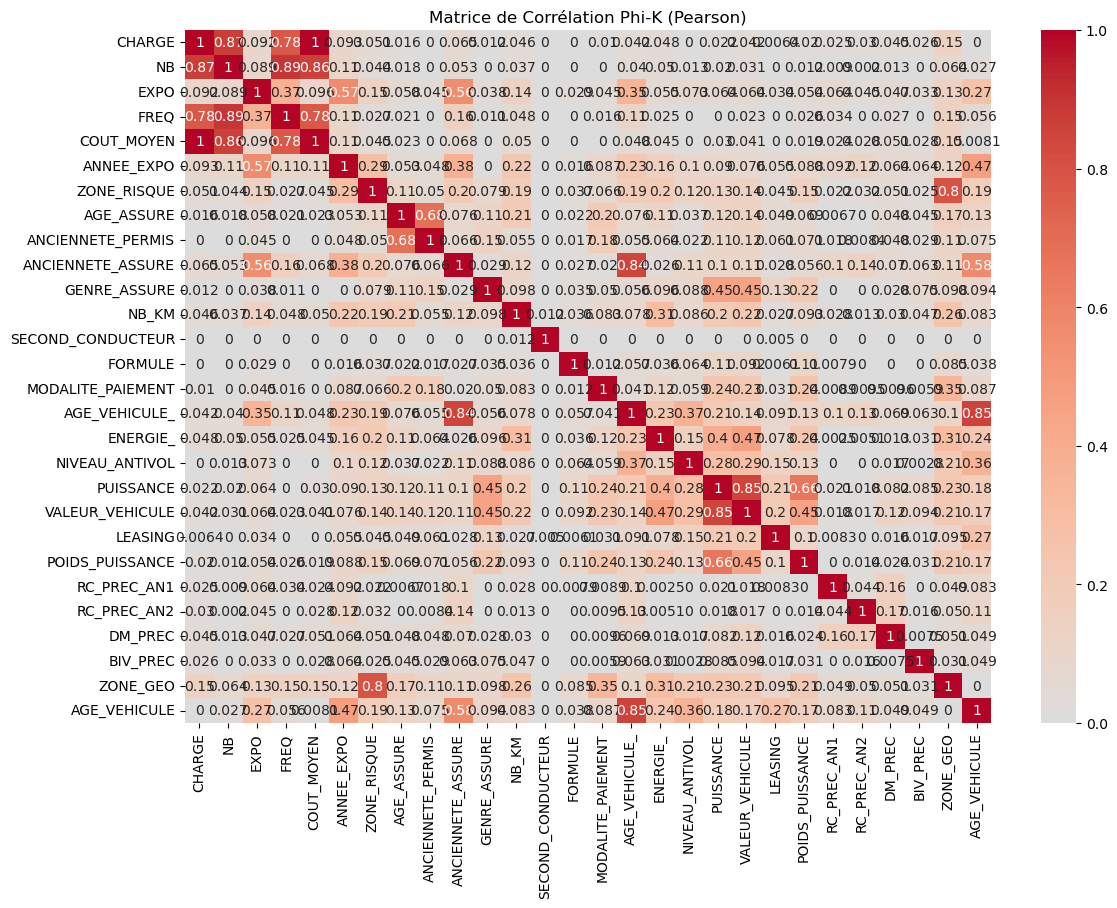

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
from phik import phik_matrix

corr_matrix = phik_matrix(categorical_df)

plt.figure(figsize=(13, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matrice de Corrélation Phi-K (Pearson)")
plt.show()


## Choisir à votre convenance le format de chaque colonne

In [ ]:
# ré-écrit

# Séparer les colonnes numériques et catégorielles
variables_num = features.select_dtypes(exclude="object").columns
variables_cat = features.select_dtypes(include="object").columns

# Récupérer les indices
numeric_indices = [i for i, col in enumerate(features.columns) if col in variables_num]
categorical_indices = [i for i, col in enumerate(features.columns) if col in variables_cat]

categorical_indices, numeric_indices

([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17],
 [0, 1, 13, 18, 19, 20, 21, 22])

## Ne pas changer le bloc ci-dessous - Split des données en base de test et bases de validation

In [39]:
# Ne pas modifier
from sklearn.model_selection import train_test_split, KFold

X = features.copy()
X_train, X_test, couts_train, couts_test, y_train, y_test = train_test_split(X, couts, y, test_size=0.2, random_state=3)

kf = KFold(n_splits=4, shuffle=True, random_state=2)
les_splits = []

for train_index, valid_index in kf.split(X_train):
    les_splits.append([train_index, valid_index])

les_splits

[[array([    1,     3,     4, ..., 31925, 31926, 31928]),
  array([    0,     2,     6, ..., 31917, 31923, 31927])],
 [array([    0,     2,     3, ..., 31926, 31927, 31928]),
  array([    1,     4,     5, ..., 31918, 31919, 31921])],
 [array([    0,     1,     2, ..., 31923, 31925, 31927]),
  array([    3,     7,    14, ..., 31924, 31926, 31928])],
 [array([    0,     1,     2, ..., 31926, 31927, 31928]),
  array([    9,    12,    13, ..., 31912, 31922, 31925])]]

## Préprocessing - A vous de jouer 

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Créer un ColumnTransformer pour l'imputation et le prétraitement des variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_indices),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_indices)
    ])


## Apprentissage supervisé tant pour la classification que la régression - A vous de jouer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import GammaRegressor

# Créer un pipeline avec prétraitement et modèle
pipeline_LogReg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = {0:1,1:9}))
])

# Créer un pipeline avec prétraitement et modèle
pipeline_GammaReg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GammaRegressor(alpha=0.85))
])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid for RandomizedSearchCV
param_grid_LogReg = {
    'model__C': [0.1, 0.5, 1],
    'model__penalty': ['l1'],
    'model__solver': ['liblinear'],
    'model__class_weight': [None, {0:1, 1:9}],
    
}
param_dist_RF = {
    'model__max_depth': [30],
    'model__min_samples_split': [2],  # 5, 10],
    'model__min_samples_leaf': [1]  # , 2, 4],
}

# Create pipeline
pipeline_LogReg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_RF = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=42))
])

# Randomized search
grid_search_LogReg = GridSearchCV(
    pipeline_LogReg,
    param_grid=param_grid_LogReg,
    scoring=["neg_root_mean_squared_error","r2"],
    refit='neg_root_mean_squared_error',
    cv=[(slice(None), slice(None))],
    verbose=1,
    n_jobs=-1
)

grid_search_RF = GridSearchCV(
    pipeline_RF,
    param_grid=param_dist_RF,
    scoring=['neg_root_mean_squared_error',"r2"],
    refit='neg_root_mean_squared_error',
    cv=[(slice(None), slice(None))],
    verbose=1,
    n_jobs=-1
)

# random_search = RandomizedSearchCV(
#     pipeline_LogReg,
#     param_distributions=param_dist_LogReg,
#     n_iter=3,
#     scoring='neg_root_mean_squared_error',
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )



In [ ]:
grid_search_LogReg.fit(X_train, couts_train)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          13,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22]),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17])])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.5, 1],
                         'model__class_weight': [None, {0: 1, 1: 9}],
                         'model__penalty': ['l1'],
                         'model__solver': ['liblinear']},
             scoring='neg_mean_absolute_error', verbose=1)

In [73]:
pd.DataFrame(grid_search_LogReg.cv_results_).sort_values(by="rank_test_score").transpose()

,0,2,4,1,3,5
mean_fit_time,3.75578,7.450393,8.924294,1.738159,2.376736,4.424609
std_fit_time,0.0,0.0,0.0,0.0,0.0,0.0
mean_score_time,0.139475,0.129121,0.122452,0.185544,0.163877,0.146068
std_score_time,0.0,0.0,0.0,0.0,0.0,0.0
param_model__C,0.1,0.5,1,0.1,0.5,1
param_model__class_weight,None,None,None,"{0: 1, 1: 9}","{0: 1, 1: 9}","{0: 1, 1: 9}"
param_model__penalty,l1,l1,l1,l1,l1,l1
param_model__solver,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear
params,"{'model__C': 0.1, 'model__class_weight': None,...","{'model__C': 0.5, 'model__class_weight': None,...","{'model__C': 1, 'model__class_weight': None, '...","{'model__C': 0.1, 'model__class_weight': {0: 1...","{'model__C': 0.5, 'model__class_weight': {0: 1...","{'model__C': 1, 'model__class_weight': {0: 1, ..."
split0_test_score,-0.052993,-0.052993,-0.052993,-0.088039,-0.0902,-0.090733


In [120]:
pipeline_RF.fit(X_train, couts_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 13, 18, 19, 20, 21,
                                                   22]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 14, 15, 16, 17])])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [91]:
grid_search_RF.fit(X_train, y_train)

Fitting 1 folds for each of 27 candidates, totalling 27 fits


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          13,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22]),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='most_frequ...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17])])),
                                       ('model',
                                        RandomForestRegressor(n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [93]:
pd.DataFrame(grid_search_RF.cv_results_).sort_values(by="rank_test_neg_root_mean_squared_error").transpose()

,18,9,19,21,10,22,12,13,20,11,...,17,0,1,3,4,2,7,6,5,8
mean_fit_time,647.639817,542.711059,631.876053,423.651432,525.245966,415.168673,594.039298,586.849616,622.406839,514.357231,...,557.987103,147.757736,147.411622,147.941145,146.397852,146.417024,148.584233,147.990593,146.707646,148.128161
std_fit_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_score_time,4.504952,7.624183,4.835105,1.592433,6.969412,1.638765,5.935494,7.494944,4.995966,7.800649,...,10.725851,1.959632,1.971912,2.24114,2.141775,1.998945,2.248595,2.079851,2.127453,2.080468
std_score_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
param_model__max_depth,30,20,30,30,20,30,20,20,30,20,...,20,10,10,10,10,10,10,10,10,10
param_model__min_samples_leaf,1,1,1,2,1,2,2,2,1,1,...,4,1,1,2,2,1,4,4,2,4
param_model__min_samples_split,2,2,5,2,5,5,2,5,10,10,...,10,2,5,2,5,10,5,2,10,10
params,"{'model__max_depth': 30, 'model__min_samples_l...","{'model__max_depth': 20, 'model__min_samples_l...","{'model__max_depth': 30, 'model__min_samples_l...","{'model__max_depth': 30, 'model__min_samples_l...","{'model__max_depth': 20, 'model__min_samples_l...","{'model__max_depth': 30, 'model__min_samples_l...","{'model__max_depth': 20, 'model__min_samples_l...","{'model__max_depth': 20, 'model__min_samples_l...","{'model__max_depth': 30, 'model__min_samples_l...","{'model__max_depth': 20, 'model__min_samples_l...",...,"{'model__max_depth': 20, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l...","{'model__max_depth': 10, 'model__min_samples_l..."
split0_test_neg_root_mean_squared_error,-0.08116,-0.105698,-0.116952,-0.126299,-0.132187,-0.13386,-0.138487,-0.144548,-0.149187,-0.158091,...,-0.175009,-0.201813,-0.204074,-0.204142,-0.204784,-0.207233,-0.207565,-0.207565,-0.20783,-0.208331
mean_test_neg_root_mean_squared_error,-0.08116,-0.105698,-0.116952,-0.126299,-0.132187,-0.13386,-0.138487,-0.144548,-0.149187,-0.158091,...,-0.175009,-0.201813,-0.204074,-0.204142,-0.204784,-0.207233,-0.207565,-0.207565,-0.20783,-0.208331


In [95]:
best_model_RF = grid_search_RF.best_estimator_

## Benchmark du model de random forest

In [ ]:
pipeline_RF.train(X_train, couts_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 13, 18, 19, 20, 21,
                                                   22]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 14, 15, 16, 17])])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [128]:
y_pred = pipeline_RF.predict(X_train)

In [129]:
qqplot_plotly(couts_train, y_pred)

In [135]:
y_pred = best_model_RF.predict(X_train)

### Rapport de classification [Random Forest] : 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30237
         1.0       1.00      1.00      1.00      1692

    accuracy                           1.00     31929
   macro avg       1.00      1.00      1.00     31929
weighted avg       1.00      1.00      1.00     31929



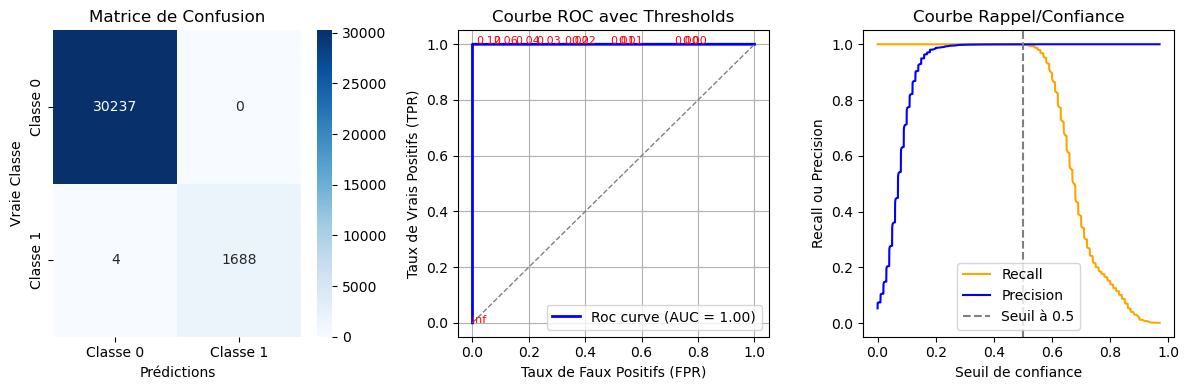

In [136]:
plot_classification_metrics("Random Forest", y_train, y_pred>0.5, y_pred)

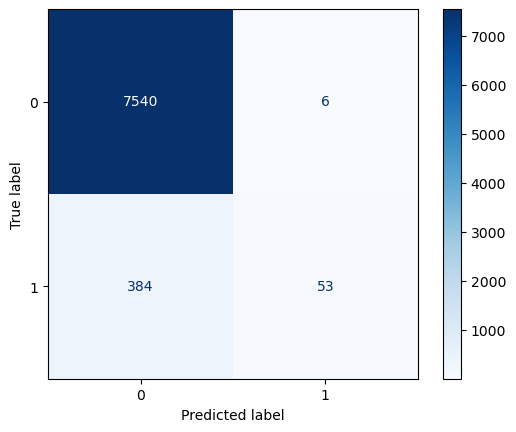

In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred>0.5)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [47]:
results = []
for train_index, valid_index in les_splits:
    
    train_x = X_train.iloc[train_index,:]
    train_y = y_train[train_index]
    train_c = couts_train[train_index]
    valid_x = X_train.iloc[valid_index,:]
    valid_y = y_train[valid_index]
    valid_c = couts_train[valid_index]

    #Trouvez le pipeline optimal pour la probabilité de sinistre
    pipeline_1 = pipeline_LogReg.fit(train_x,train_y) 
    pred_1 = pipeline_1.predict(valid_x)
    
    #Trouvez le pipeline optimal pour le coût d'un sinistre
    pipeline_2 = pipeline_GammaReg.fit(train_x[train_y>0],train_c[train_y>0]) 
    pred_2 = pipeline_2.predict(valid_x)

    # Reconstitution de la base global en concaténation step by step des folds via valid_index
    df_test = valid_x.copy()
    df_test['cout'] = valid_c
    df_test['y'] = valid_c
    df_test.loc[df_test['y'] > 0, 'y'] = 1 
    df_test['pred_c'] = pred_2
    df_test['pred_y'] = pred_1
    df_test['pred_prime'] = [max(5,x) for x in (pred_1 * pred_2)]

    # Concaténation des folds
    results.append(df_test) 
    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Concaténation des bases de validation enrichies

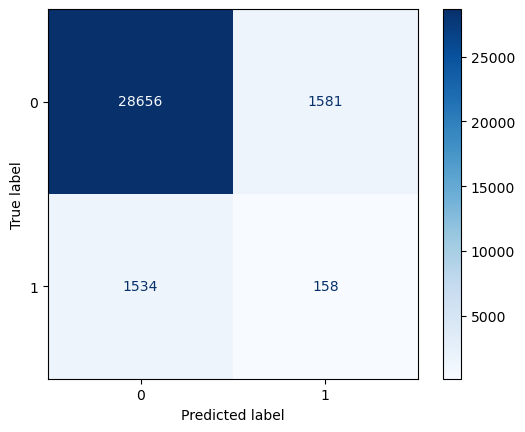

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(df_results['y'], df_results['pred_y'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [74]:
X_test.columns

Index(['ANNEE_EXPO', 'ANNEE_VEHICULE', 'ZONE_RISQUE', 'AGE_ASSURE',
       'ANCIENNETE_PERMIS', 'ANCIENNETE_ASSURE', 'GENRE_ASSURE', 'NB_KM',
       'SECOND_CONDUCTEUR', 'FORMULE', 'MODALITE_PAIEMENT', 'AGE_VEHICULE_',
       'ENERGIE_', 'NIVEAU_ANTIVOL', 'PUISSANCE', 'VALEUR_VEHICULE', 'LEASING',
       'POIDS_PUISSANCE', 'RC_PREC_AN1', 'RC_PREC_AN2', 'DM_PREC', 'BIV_PREC',
       'ZONE_GEO'],
      dtype='object')

In [ ]:
cm = confusion_matrix(df_results['y'], df_results['pred_y'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import GammaRegressor

# modif
pipeline_LogReg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# modif
pipeline_GammaReg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GammaRegressor(alpha=0.85))
])

pipeline_GammaReg.fit(X_train[y_train>0], couts_train[y_train>0])
y_pred = pipeline_GammaReg.predict(X_test) * X_test['EXPO']



KeyError: 'EXPO'

In [109]:
qqplot_plotly(y_train, y_pred)

In [108]:
import numpy as np
import pandas as pd
import plotly.express as px

def qqplot_plotly(y_true, y_pred, title="QQ Plot"):
    """
    Trace un QQ-plot entre deux séries avec plotly express.
    y_true : valeurs observées
    y_pred : valeurs prédites
    """
    y_true_sorted = np.sort(y_true)
    y_pred_sorted = np.sort(y_pred)
    min_len = min(len(y_true_sorted), len(y_pred_sorted))
    df = pd.DataFrame({
        "Observed": y_true_sorted[:min_len],
        "Predicted": y_pred_sorted[:min_len]
    })
    fig = px.scatter(df, x="Observed", y="Predicted", title=title)
    fig.add_shape(
        type="line",
        x0=df["Observed"].min(), y0=df["Observed"].min(),
        x1=df["Observed"].max(), y1=df["Observed"].max(),
        line=dict(color="red", dash="dash"),
        name="y=x"
    )
    fig.update_layout(showlegend=False)
    fig.show()

In [48]:
df_results.iloc[:,-5:].query("cout > 0 ")

,cout,y,pred_c,pred_y,pred_prime
30006,6967.35,1.0,2284.382133,0.0,5.000000
33998,1017.34,1.0,2128.192061,1.0,2128.192061
11291,3170.82,1.0,2567.688546,0.0,5.000000
32620,3903.92,1.0,2455.018952,0.0,5.000000
10948,3656.62,1.0,2349.308411,0.0,5.000000
...,...,...,...,...,...
20757,406.54,1.0,2105.221552,0.0,5.000000
6587,2500.00,1.0,2654.082490,0.0,5.000000
24295,4019.15,1.0,2009.801729,0.0,5.000000
6087,2500.00,1.0,2228.823547,0.0,5.000000


In [27]:
df_results = pd.concat(results,axis=0)
df_results.head()

,ANNEE_EXPO,ANNEE_VEHICULE,ZONE_RISQUE,AGE_ASSURE,ANCIENNETE_PERMIS,ANCIENNETE_ASSURE,GENRE_ASSURE,NB_KM,SECOND_CONDUCTEUR,FORMULE,...,RC_PREC_AN1,RC_PREC_AN2,DM_PREC,BIV_PREC,ZONE_GEO,cout,y,pred_c,pred_y,pred_prime
4818,2021,2017,D,"(55,65]","(25,60]","(-1,0]",M,"(30k,40k]",NaN,L1,...,0.0,0.0,0.0,0.0,75,0.0,0.0,2058.921393,0.0,5.0
10584,2020,2019,D,"(35,40]","(12,25]","(-1,0]",F,"(5k,15k]",NaN,L1,...,0.0,0.0,0.0,0.0,35,0.0,0.0,2063.587620,0.0,5.0
7553,2022,2017,D,"(55,65]","(25,60]","(2,5]",M,"(5k,15k]",OUI,L1,...,0.0,0.0,0.0,0.0,35,0.0,0.0,2450.749764,0.0,5.0
34637,2022,2019,E,"(30,35]","(8,12]","(1,2]",F,"(5k,15k]",NaN,L1,...,0.0,0.0,0.0,0.0,48,0.0,0.0,2194.835556,0.0,5.0
11521,2021,2017,C,"(65,75]","(25,60]","(2,5]",M,"(15k,30k]",OUI,L1,...,0.0,0.0,0.0,0.0,56,0.0,0.0,2271.788684,0.0,5.0


In [94]:
df_results[['pred_y','pred_c','pred_prime']].describe()

,pred_y,pred_c,pred_prime
count,31929.000000,31929.000000,31929.000000
mean,0.054465,2293.230235,124.518384
std,0.226936,193.787194,500.187163
min,0.000000,1501.489498,5.000000
25%,0.000000,2159.491259,5.000000
50%,0.000000,2283.982140,5.000000
75%,0.000000,2413.701735,5.000000
max,1.000000,3673.478220,3271.802027


## Mesures de performances

In [95]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, f1_score

<b>Variable proba de sinistres</b>

In [96]:
f1_score(df_results['y'] , df_results['pred_y'])

0.09210142815505684

<b>Variable cout</b>

In [97]:
df_results.loc[df_results.cout>0,'cout'].std()

2766.3707301317136

In [98]:
root_mean_squared_error(df_results.loc[df_results.cout>0,'cout'] , df_results.loc[df_results.cout>0,'pred_c'])

2763.504107257006

In [99]:
mean_absolute_error(df_results.loc[df_results.cout>0,'cout'] , df_results.loc[df_results.cout>0,'pred_c'])

1774.9269528747473

<b>Variable prime</b>

In [100]:
df_results['pred_prime'].std()

500.18716303516857

In [101]:
root_mean_squared_error(df_results['cout'] , df_results['pred_prime'])

949.8103645591395

In [102]:
df_results['cout'].sum()/df_results['pred_prime'].sum()

0.9787278793417434

## Interprétabilité et validation des modèles construits

```
- Zoomer sur l'importance des variables de manière intrinsèque ou agnostique
- Utiliser le package shap pour une approche globale ou locale
```

## Performance par segment
Changez les segments à votre guise pour analyser les résultats ou pour combiner des modèles et ainsi performer la prédiction des primes

In [103]:
segmentation = ['GENRE_ASSURE','ANCIENNETE_PERMIS']

df1 = df_results[segmentation + ['y','pred_y']].groupby(segmentation).apply(lambda x: f1_score(x['y'],x['pred_y'],zero_division=False),include_groups=False).reset_index()
df2 = df_results[segmentation + ['cout','pred_c']].groupby(segmentation).apply(lambda x: root_mean_squared_error(x['cout'],x['pred_c']),include_groups=False).reset_index()
df3 = df_results[segmentation + ['cout','pred_prime']].groupby(segmentation).apply(lambda x: root_mean_squared_error(x['cout'],x['pred_prime']),include_groups=False).reset_index()
df4 = df_results[segmentation + ['cout']].groupby(segmentation).count().reset_index()
df1.columns = segmentation + ['f1_score']
df2.columns = segmentation + ['rmse_c']
df3.columns = segmentation + ['rmse_prime']
df4.columns = segmentation + ['count']
df5 = df1.merge(df2)
df5 = df5.merge(df3)
df5 = df5.merge(df4)  

In [104]:
df5

,GENRE_ASSURE,ANCIENNETE_PERMIS,f1_score,rmse_c,rmse_prime,count
0,F,"(0,1]",0.000000,2183.008876,5.000000,3
1,F,"(1,2]",0.000000,2233.653308,5.000000,8
2,F,"(12,25]",0.130548,2228.847776,911.149186,2993
3,F,"(2,4]",0.000000,2656.431789,2047.650035,44
4,F,"(25,60]",0.079188,2264.061684,844.854603,9897
5,F,"(4,6]",0.000000,2184.259960,827.689760,102
6,F,"(6,8]",0.000000,2226.564669,596.030069,218
7,F,"(8,12]",0.118812,2217.769593,923.823390,604
8,M,"(0,1]",0.000000,2100.293842,5.000000,1
9,M,"(12,25]",0.060403,2371.019751,994.118098,2874


## Prédiction sur la base de test

In [105]:
#Comment prédire sur la base de test ?
pipeline_1 = pipeline_LogReg.fit(X_train,y_train)
pred_1 = pipeline_1.predict(X_test)
pipeline_2 = pipeline_GammaReg.fit(X_train[y_train>0],couts_train[y_train>0])
pred_2 = pipeline_2.predict(X_test)
df_TEST = X_test.copy()
df_TEST['cout'] = couts_test
df_TEST['y'] = couts_test
df_TEST.loc[df_TEST['y'] > 0, 'y'] = 1 
df_TEST['pred_y'] = pred_1
df_TEST['pred_c'] = pred_2
df_TEST['pred_prime'] = [max(5,x) for x in (pred_1 * pred_2)]

In [106]:
df_TEST['cout'].sum()/df_TEST['pred_prime'].sum()

1.0100206713483717

In [107]:
root_mean_squared_error(df_TEST['cout'] , df_TEST['pred_prime'])

900.6124656106161